In [20]:
# Same as mmm_mmstd_mrsos.ipynb.
# Here we compute the statistics for tas, but for the same models that have mrsos.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import cftime
from scipy.interpolate import griddata
import matplotlib as mpl

In [16]:
# Define the variable of interest and its units and range of validity.

varname = 'tas' # We can compute its trend and compare it to the MMM with fig1 here https://www.nature.com/articles/s41612-023-00410-6 (Zhang et al., npjCAS, 2023)
varname_path = 'tas'
description = '2m air temperature'
units = 'K'
levels = np.arange(235,325,10)
levels_MMbias = np.arange(-11,13,2)

"""
varname = 'z500'
varname_path = 'zg'
description = '500hPa geopotential height'
units = 'm'
levels = np.arange(5000,6100,100)
levels_MMbias = np.arange(-105,115,10)
"""

"\nvarname = 'z500'\nvarname_path = 'zg'\ndescription = '500hPa geopotential height'\nunits = 'm'\nlevels = np.arange(5000,6100,100)\nlevels_MMbias = np.arange(-105,115,10)\n"

In [19]:
path2era5 = '/bdd/ERA5/NETCDF/GLOBAL_025/1xmonthly/AN_SF/' # Soil Moisture is not already downloaded, but here the t2m, sstk and msl monthly fields are available.
path2cmip6 = '/bdd/CMIP6/CMIP/'

In [20]:
# Read a single ERA5 file to get the coordinates.
ds_era5 = xr.open_dataset(path2era5+'2020/t2m.2020.asme5.GLOBAL_025.nc')
lon = ds_era5.longitude.values
lat = ds_era5.latitude.values

extent = [360-110, 360-90, 30, 50] # minlon, maxlon, minlat, maxlat, areas of interet in CONUS, defined in Teng et al. (2019)

In [5]:
# Compute the annual mmm for tas in the time window 197901-201412, considering the models that have mrsos.
# Here we compute the mean for each model (all members averaged), but the overall MMM is computed with all members having the same weight.

d_mean4MMM = 0
counter = 0
overall_member_counter = 0

list_of_folders = os.listdir(path2cmip6)
for folder in list_of_folders:
    list_of_models = os.listdir(path2cmip6 + folder)
    for model in list_of_models: 
        list_of_runs = os.listdir(path2cmip6 + folder + '/' + model) # 'historical', 'amip', 'piControl', 'abrupt-4xCO2', etc.
        if 'historical' in list_of_runs: #  Print the name of the models which have the historical run.
            print('# ',model)
            first_field = 1 # We want to average all the ensemble members of a given model.
            path2members = path2cmip6 + folder + '/' + model +'/historical/'
            list_of_members_etal = os.listdir(path2members)
            # Select only the ensemble members and skip the '.paths.txt' entries.
            list_of_members = [idx for idx in list_of_members_etal if idx[0].lower() == 'r'.lower()]
            member_counter = 0

            for member in list_of_members: # Print the ensemble members that have info on the mrsos.
            ########### HERE WE ARE CONSIDERING ALL FOLDERS WHICH HAVE THE mrsos FOLDER, WHICH ARE 10 MORE THAN THOSE THAT ACTUALLY HAVE THE DATA!!! ###########
            # We could build the list of models and members that have mrsos data and simply read them in loop.
                
                if os.path.exists(path2members + member + '/Lmon/mrsos/'):
                    if os.path.exists(path2members + member + '/Amon/'+varname_path+'/gr/latest/'):
                        path2files = path2members + member + '/Amon/'+varname_path+'/gr/latest/'
                    elif os.path.exists(path2members + member + '/Amon/'+varname_path+'/gr1/latest/'):
                        path2files = path2members + member + '/Amon/'+varname_path+'/gr1/latest/'
                    elif os.path.exists(path2members + member + '/Amon/'+varname_path+'/gn/latest/'):
                        path2files = path2members + member + '/Amon/'+varname_path+'/gn/latest/'
                    else:
                        path2files = ''

                    if path2files: # If some data are available the path2file is not empty.
                        # Open and concatenate all the files whose final date is after 197901.
                        list_of_files = sorted(os.listdir(path2files))
                        # print('list_of_files =', list_of_files) # There is a member in EC-Earth that has no file but it read anyhow...
                        if list_of_files: # Check whether there are output files to be read.
                            first_file = 1
                            for ll in range(len(list_of_files)):
                                filename = list_of_files[ll]
                                final_date = filename[-9:-3]
                                if int(final_date)>197901: # Here the instant_start is re-written in the form of YYYYMM.
                                    da = xr.open_dataset(path2files + filename)
                                    # Read the variable of interest, so that the reading is faster.
                                    if varname=='z500': # Select the variable at the right pressure level.
                                        da_var = da['zg'].sel(plev=50000,method='nearest')
                                    else:
                                        da_var = da[varname]

                                    if first_file:
                                        db = da_var
                                        first_file = 0
                                    else:
                                        db = xr.concat([db,da_var],dim='time')

                            # Select the time window according to the type of time axis.
                            if db.time.dtype=='datetime64[ns]':
                                instant_start = np.datetime64('1979-01-01')
                                instant_end = np.datetime64('2014-12-31')
                            else:
                                if db.time.values[0].calendar=='noleap':
                                    instant_start = cftime.DatetimeNoLeap(1979,1,1,0,0,0,0,has_year_zero=True)
                                    instant_end = cftime.DatetimeNoLeap(2014,12,31,0,0,0,0,has_year_zero=True)
                                elif db.time.values[0].calendar=='360_day':
                                    instant_start = cftime.Datetime360Day(1979,1,1,0,0,0,0,has_year_zero=False)
                                    instant_end = cftime.Datetime360Day(2014,12,17,0,0,0,0,has_year_zero=False)     

                            # Compute the temporal mean in the time frame of interest and interpolate it on the ERA5 grid.   
                            d_mean = db.sel(time=slice(instant_start,instant_end)).mean(dim='time')
                            d_mean_i = d_mean.interp(lon=ds_era5.longitude,lat=ds_era5.latitude)

                            if np.sum(np.isnan(d_mean_i.values))<450e3: # This is to remove the NorCPM1 ensemble members which has some large stripes of NaNs in tas.
                                if first_field:
                                    d_model_mean = d_mean_i
                                    first_field=0
                                else:
                                    d_model_mean += d_mean_i
                                counter += 1
                                member_counter += 1 # This is set to zero for each model.                                  
            
                print('Ensemble member '+str(member_counter)+' out of '+str(len(list_of_members)))

            if member_counter>0: # Plot the figure if there is at least one member with a valid field.

                d_mean4MMM += d_model_mean # Compute the MMM by summing all the terms.

                # Plot the map of the mean value for a given model.
                model_mean = d_model_mean.values/member_counter
                """
                fig = plt.figure(figsize=(14,6))
                pc = plt.contourf(lon,lat,model_mean,levels=levels)#,cmap='BrBG')
                #plt.plot([extent[0],extent[1],extent[1],extent[0],extent[0]],[extent[2],extent[2],extent[3],extent[3],extent[2]],'k')
                plt.xlabel('Longitude [°E]',fontsize=14)
                plt.ylabel('Latitude [°N]',fontsize=14)
                plt.ylim([-60,90])
                plt.tick_params(axis='both',labelsize=14)

                cb = plt.colorbar(pc)
                cb.ax.tick_params(labelsize=12)

                plt.title(model+ ' model mean ('+str(member_counter)+' members) '+ description +' ['+units+']',fontsize=16)
                plt.savefig('model_mean_' + model + '_'+varname+'_1979-2014.png',bbox_inches='tight')

                plt.close(fig)
                """
                del model_mean, d_model_mean

            overall_member_counter += member_counter
                                        
    print('----------')
    
print('Number of members actually used: '+ str(counter))

# By plotting the model mean of tas I see that NorCPM1 has some stripes of NaN, that then appear on the MMM, as well.
# We need to check whether it is a single member or all members of this model have the same issue.

#  IPSL-CM6A-LR
Ensemble member 1 out of 33
Ensemble member 2 out of 33
Ensemble member 3 out of 33
Ensemble member 4 out of 33
Ensemble member 5 out of 33
Ensemble member 6 out of 33
Ensemble member 7 out of 33
Ensemble member 8 out of 33
Ensemble member 9 out of 33
Ensemble member 10 out of 33
Ensemble member 11 out of 33
Ensemble member 12 out of 33
Ensemble member 13 out of 33
Ensemble member 14 out of 33
Ensemble member 15 out of 33
Ensemble member 16 out of 33
Ensemble member 17 out of 33
Ensemble member 18 out of 33
Ensemble member 19 out of 33
Ensemble member 20 out of 33
Ensemble member 21 out of 33
Ensemble member 22 out of 33
Ensemble member 23 out of 33
Ensemble member 24 out of 33
Ensemble member 25 out of 33
Ensemble member 26 out of 33
Ensemble member 27 out of 33
Ensemble member 28 out of 33
Ensemble member 29 out of 33
Ensemble member 30 out of 33
Ensemble member 31 out of 33
Ensemble member 32 out of 33
Ensemble member 33 out of 33
#  IPSL-CM5A2-INCA
Ensemble member 0

/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 1 out of 3


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 2 out of 3


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 3 out of 3
#  CESM2-WACCM-FV2


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 1 out of 3


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 2 out of 3


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 3 out of 3
#  CESM2-FV2


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 1 out of 4


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 2 out of 4
Ensemble member 2 out of 4


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 3 out of 4
#  CESM2


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 1 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 2 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 3 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 4 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 5 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 6 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 7 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 8 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 9 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 10 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 11 out of 11
----------
#  FGOALS-f3-L
Ensemble member 1 out of 3
Ensemble member 2 out of 3
Ensemble member 3 out of 3
#  CAS-ESM2-0
Ensemble member 0 out of 4
Ensemble member 1 out of 4
Ensemble member 2 out of 4
Ensemble member 3 out of 4
#  FGOALS-g3
Ensemble member 1 out of 6
Ensemble member 2 out of 6
Ensemble member 3 out of 6
Ensemble member 4 out of 6
Ensemble member 5 out of 6
Ensemble member 6 out of 6
----------
#  SAM0-UNICON
Ensemble member 1 out of 1
----------
#  UKESM1-0-LL
Ensemble member 1 out of 16
Ensemble member 2 out of 16
Ensemble member 3 out of 16
Ensemble member 4 out of 16
Ensemble member 5 out of 16
Ensemble member 6 out of 16
Ensemble member 7 out of 16
Ensemble member 8 out of 16
Ensemble member 9 out of 16
Ensemble member 10 out of 16
Ensemble member 11 out of 16
Ensemble member 12 out of 16
Ensemble member 13 out of 16
Ensemble member 14 out of 16
Ensemble member 15 out of 16
Ensemble member 16 out of 16
#  HadGEM3-GC31-LL
Ensemble membe

In [6]:
# Save the MMM as netcdf file.

d_mean_variable = d_mean4MMM.assign_attrs(counter=counter, units=units)
d_mean_variable.to_netcdf('MMM_'+varname)

d_mean_variable.attrs

{'counter': 476, 'units': 'm'}

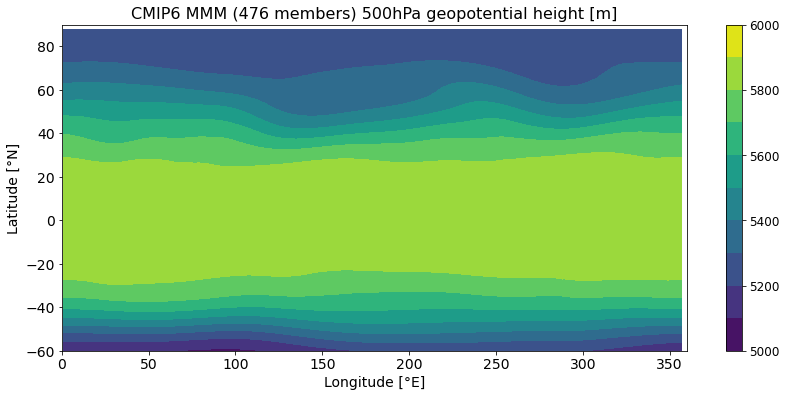

In [8]:
mean_variable = d_mean4MMM.values/counter

fig = plt.figure(figsize=(14,6))
pc = plt.contourf(lon,lat,mean_variable,levels=levels)#,cmap='RdYlBu')
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)

cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)

plt.title('CMIP6 MMM ('+str(counter)+' members) '+description+' ['+units+']',fontsize=16)
plt.savefig('mmm_'+varname+'_1979-2014_allmodels.png')

In [21]:
################################## SEASONAL ###############################################
label_season = 'JJA'

In [22]:
# Compute the seasonal mmm for tas in the time window 197901-201412, considering the models that have mrsos.
# Here we compute the mean for each model (all members averaged), but the overall MMM is computed with all members having the same weight.

d_mean4MMM_seasonal = 0
counter = 0
overall_member_counter = 0

list_of_folders = os.listdir(path2cmip6)
for folder in list_of_folders:
    list_of_models = os.listdir(path2cmip6 + folder)
    for model in list_of_models: 
        list_of_runs = os.listdir(path2cmip6 + folder + '/' + model) # 'historical', 'amip', 'piControl', 'abrupt-4xCO2', etc.
        if 'historical' in list_of_runs: #  Print the name of the models which have the historical run.
            print('# ',model)
            first_field = 1 # We want to average all the ensemble members of a given model.
            path2members = path2cmip6 + folder + '/' + model +'/historical/'
            list_of_members_etal = os.listdir(path2members)
            # Select only the ensemble members and skip the '.paths.txt' entries.
            list_of_members = [idx for idx in list_of_members_etal if idx[0].lower() == 'r'.lower()]
            member_counter = 0
            
            for member in list_of_members: # Print the ensemble members that have info on the mrsos.
            ########### HERE WE ARE CONSIDERING ALL FOLDERS WHICH HAVE THE mrsos FOLDER, WHICH ARE 10 MORE THAN THOSE THAT ACTUALLY HAVE THE DATA!!! ###########
            # We could build the list of models and members that have mrsos data and simply read them in loop.
                
                if os.path.exists(path2members + member + '/Lmon/mrsos/'):
                    if os.path.exists(path2members + member + '/Amon/'+varname_path+'/gr/latest/'):
                        path2files = path2members + member + '/Amon/'+varname_path+'/gr/latest/'
                    elif os.path.exists(path2members + member + '/Amon/'+varname_path+'/gr1/latest/'):
                        path2files = path2members + member + '/Amon/'+varname_path+'/gr1/latest/'
                    elif os.path.exists(path2members + member + '/Amon/'+varname_path+'/gn/latest/'):
                        path2files = path2members + member + '/Amon/'+varname_path+'/gn/latest/'
                    else:
                        path2files = ''

                    if path2files: # If some data are available the path2file is not empty.
                        # Open and concatenate all the files whose final date is after 197901.
                        list_of_files = sorted(os.listdir(path2files))
                        #print('list_of_files =', list_of_files) # There is a member in EC-Earth that has no file but it read anyhow...
                        if list_of_files: # Check whether there are output files to be read.
                            first_file = 1
                            for ll in range(len(list_of_files)):
                                filename = list_of_files[ll]
                                final_date = filename[-9:-3]
                                if int(final_date)>197901: # Here the instant_start is re-written in the form of YYYYMM.
                                    da = xr.open_dataset(path2files + filename)
                                    # Read the variable of interest, so that the reading is faster.
                                    if varname=='z500': # Select the variable at the right pressure level.
                                        da_var = da['zg'].sel(plev=50000,method='nearest')
                                    else:
                                        da_var = da[varname]

                                    if first_file:
                                        db = da_var
                                        first_file = 0
                                    else:
                                        db = xr.concat([db,da_var],dim='time')
                                       
                                        
                            # Select the time window according to the type of time axis.
                            if db.time.dtype=='datetime64[ns]':
                                instant_start = np.datetime64('1979-01-01')
                                instant_end = np.datetime64('2014-12-31')
                            else:
                                if db.time.values[0].calendar=='noleap':
                                    instant_start = cftime.DatetimeNoLeap(1979,1,1,0,0,0,0,has_year_zero=True)
                                    instant_end = cftime.DatetimeNoLeap(2014,12,31,0,0,0,0,has_year_zero=True)
                                elif db.time.values[0].calendar=='360_day':
                                    instant_start = cftime.Datetime360Day(1979,1,1,0,0,0,0,has_year_zero=False)
                                    instant_end = cftime.Datetime360Day(2014,12,17,0,0,0,0,has_year_zero=False)     

                            # Compute the seasonal mean in the time frame of interest and interpolate it on the ERA5 grid.
                            d_time = db.sel(time=slice(instant_start,instant_end)) # Select the time window.
                            d_season = d_time.groupby('time.season').mean('time').sel(season=label_season) # Select the season.
                            d_season_i = d_season.interp(lon=ds_era5.longitude,lat=ds_era5.latitude) # Interpolate.
            
                            if np.sum(np.isnan(d_season_i.values))<450e3: # This is to remove the NorCPM1 ensemble members which has some large stripes of NaNs in tas.
                                if first_field:
                                    d_model_mean = d_season_i
                                    first_field=0
                                else:
                                    d_model_mean += d_season_i
                                counter += 1
                                member_counter += 1 # This is set to zero for each model. 
                                
                print('Ensemble member '+str(member_counter)+' out of '+str(len(list_of_members)))
            
            if member_counter>0: # Plot the figure if there is at least one member with a valid field.

                d_mean4MMM_seasonal += d_model_mean # Compute the MMM by summing all the terms.
                del d_model_mean

            overall_member_counter += member_counter
                                        
    print('----------')
    
print('Number of members actually used: '+ str(counter))

#  IPSL-CM6A-LR
Ensemble member 1 out of 33
Ensemble member 2 out of 33
Ensemble member 3 out of 33
Ensemble member 4 out of 33
Ensemble member 5 out of 33
Ensemble member 6 out of 33
Ensemble member 7 out of 33
Ensemble member 8 out of 33
Ensemble member 9 out of 33
Ensemble member 10 out of 33
Ensemble member 11 out of 33
Ensemble member 12 out of 33
Ensemble member 13 out of 33
Ensemble member 14 out of 33
Ensemble member 15 out of 33
Ensemble member 16 out of 33
Ensemble member 17 out of 33
Ensemble member 18 out of 33
Ensemble member 19 out of 33
Ensemble member 20 out of 33
Ensemble member 21 out of 33
Ensemble member 22 out of 33
Ensemble member 23 out of 33
Ensemble member 24 out of 33
Ensemble member 25 out of 33
Ensemble member 26 out of 33
Ensemble member 27 out of 33
Ensemble member 28 out of 33
Ensemble member 29 out of 33
Ensemble member 30 out of 33
Ensemble member 31 out of 33
Ensemble member 32 out of 33
Ensemble member 33 out of 33
#  IPSL-CM5A2-INCA
Ensemble member 1

/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 1 out of 3


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 2 out of 3


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 3 out of 3
#  CESM2-WACCM-FV2


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 1 out of 3


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 2 out of 3


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 3 out of 3
#  CESM2-FV2


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 1 out of 4


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 2 out of 4
Ensemble member 2 out of 4


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 3 out of 4
#  CESM2


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 1 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 2 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 3 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 4 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 5 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 6 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 7 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 8 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 9 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 10 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 11 out of 11
----------
#  FGOALS-f3-L
Ensemble member 1 out of 3
Ensemble member 2 out of 3
Ensemble member 3 out of 3
#  CAS-ESM2-0
Ensemble member 1 out of 4
Ensemble member 2 out of 4
Ensemble member 3 out of 4
Ensemble member 4 out of 4
#  FGOALS-g3
Ensemble member 1 out of 6
Ensemble member 2 out of 6
Ensemble member 3 out of 6
Ensemble member 4 out of 6
Ensemble member 5 out of 6
Ensemble member 6 out of 6
----------
#  SAM0-UNICON
Ensemble member 1 out of 1
----------
#  UKESM1-0-LL
Ensemble member 1 out of 16
Ensemble member 2 out of 16
Ensemble member 3 out of 16
Ensemble member 4 out of 16
Ensemble member 5 out of 16
Ensemble member 6 out of 16
Ensemble member 7 out of 16
Ensemble member 8 out of 16
Ensemble member 9 out of 16
Ensemble member 10 out of 16
Ensemble member 11 out of 16
Ensemble member 12 out of 16
Ensemble member 13 out of 16
Ensemble member 14 out of 16
Ensemble member 15 out of 16
Ensemble member 16 out of 16
#  HadGEM3-GC31-LL
Ensemble membe

In [23]:
# Save the seasonal MMM as netcdf file.

d_mean_season = d_mean4MMM_seasonal.assign_attrs(counter=counter, units=units)
d_mean_season.to_netcdf(label_season + '_MMM_'+varname)

d_mean_season.attrs

{'counter': 498, 'units': 'K'}

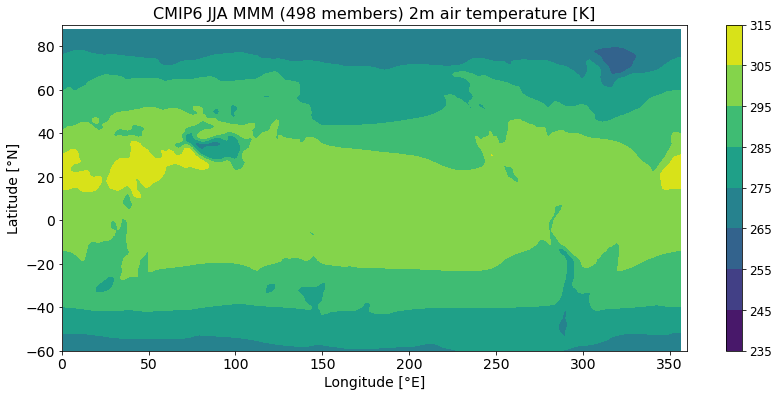

In [24]:
# Read the seasonal mean from the netcdf file.
d_mean_season_nc = xr.open_dataset(label_season + '_MMM_'+varname)
counter = d_mean_season_nc[varname_path].attrs['counter']
mean_seasonal = d_mean_season_nc[varname_path].values/counter

fig = plt.figure(figsize=(14,6))
pc = plt.contourf(lon,lat,mean_seasonal,levels=levels)#,cmap='RdYlBu')
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)

cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)

plt.title('CMIP6 ' + label_season + ' MMM ('+str(counter)+' members) '+description+' ['+units+']',fontsize=16)
plt.savefig('mmm_'+varname+'_'+label_season+'_1979-2014_allmodels.png',bbox_inches='tight')

In [ ]:
# Plot the difference between the annual and the seasonal MMM   #####################################################

fig = plt.figure(figsize=(14,6))
pc = plt.contourf(lon,lat,mean_seasonal,levels=levels)#,cmap='RdYlBu')
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)

cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)


In [10]:
# Compute the seasonal MMbias for atm variable of interest in the time window 197901-201412, considering the models that have mrsos.

counter = 0
overall_member_counter = 0

list_of_folders = os.listdir(path2cmip6)
for folder in list_of_folders:
    list_of_models = os.listdir(path2cmip6 + folder)
    for model in list_of_models: 
        list_of_runs = os.listdir(path2cmip6 + folder + '/' + model) # 'historical', 'amip', 'piControl', 'abrupt-4xCO2', etc.
        if 'historical' in list_of_runs: #  Print the name of the models which have the historical run.
            print('# ',model)
            first_field = 1 # We want to average all the ensemble members of a given model.
            path2members = path2cmip6 + folder + '/' + model +'/historical/'
            list_of_members_etal = os.listdir(path2members)
            # Select only the ensemble members and skip the '.paths.txt' entries.
            list_of_members = [idx for idx in list_of_members_etal if idx[0].lower() == 'r'.lower()]
            member_counter = 0

            for member in list_of_members: # Print the ensemble members that have info on the mrsos.
            ########### HERE WE ARE CONSIDERING ALL FOLDERS WHICH HAVE THE mrsos FOLDER, WHICH ARE 10 MORE THAN THOSE THAT ACTUALLY HAVE THE DATA!!! ###########
            # We could build the list of models and members that have mrsos data and simply read them in loop.
                
                if os.path.exists(path2members + member + '/Lmon/mrsos/'):
                    if os.path.exists(path2members + member + '/Amon/'+varname_path+'/gr/latest/'):
                        path2files = path2members + member + '/Amon/'+varname_path+'/gr/latest/'
                    elif os.path.exists(path2members + member + '/Amon/'+varname_path+'/gr1/latest/'):
                        path2files = path2members + member + '/Amon/'+varname_path+'/gr1/latest/'
                    elif os.path.exists(path2members + member + '/Amon/'+varname_path+'/gn/latest/'):
                        path2files = path2members + member + '/Amon/'+varname_path+'/gn/latest/'
                    else:
                        path2files = ''

                    if path2files: # If some data are available the path2file is not empty.
                        # Open and concatenate all the files whose final date is after 197901.
                        list_of_files = sorted(os.listdir(path2files))
                        # print('list_of_files =', list_of_files) # There is a member in EC-Earth that has no file but it read anyhow...
                        if list_of_files: # Check whether there are output files to be read.
                            first_file = 1
                            for ll in range(len(list_of_files)):
                                filename = list_of_files[ll]
                                final_date = filename[-9:-3]
                                if int(final_date)>197901: # Here the instant_start is re-written in the form of YYYYMM.
                                    da = xr.open_dataset(path2files + filename)
                                    # Read the variable of interest, so that the reading is faster.
                                    if varname=='z500': # Select the variable at the right pressure level.
                                        da_var = da['zg'].sel(plev=50000,method='nearest')
                                    else:
                                        da_var = da[varname]

                                    if first_file:
                                        db = da_var
                                        first_file = 0
                                    else:
                                        db = xr.concat([db,da_var],dim='time')
                            
                            # Select the time window according to the type of time axis.
                            if db.time.dtype=='datetime64[ns]':
                                instant_start = np.datetime64('1979-01-01')
                                instant_end = np.datetime64('2014-12-31')
                            else:
                                if db.time.values[0].calendar=='noleap':
                                    instant_start = cftime.DatetimeNoLeap(1979,1,1,0,0,0,0,has_year_zero=True)
                                    instant_end = cftime.DatetimeNoLeap(2014,12,31,0,0,0,0,has_year_zero=True)
                                elif db.time.values[0].calendar=='360_day':
                                    instant_start = cftime.Datetime360Day(1979,1,1,0,0,0,0,has_year_zero=False)
                                    instant_end = cftime.Datetime360Day(2014,12,17,0,0,0,0,has_year_zero=False)     

                            # Compute the seasonal mean in the time frame of interest and interpolate it on the ERA5 grid.
                            d_time = db.sel(time=slice(instant_start,instant_end)) # Select the time window.
                            d_season = d_time.groupby('time.season').mean('time').sel(season=label_season) # Select the season.
                            d_season_i = d_season.interp(lon=ds_era5.longitude,lat=ds_era5.latitude) # Interpolate.
                            
                            if np.sum(np.isnan(d_season_i.values))<450e3: # This is to remove the NorCPM1 ensemble members which has some large stripes of NaNs in tas.
                                if first_field:
                                    d_mean4bias = d_season_i.values - mean_seasonal
                                    first_field=0
                                else:
                                    d_mean4bias += d_season_i.values - mean_seasonal
                                counter += 1
                                member_counter += 1 # This is set to zero for each model. 
                                
                print('Ensemble member '+str(member_counter)+' out of '+str(len(list_of_members)))

            if member_counter>0: # Plot the figure if there is at least one member with a valid field.

                # Plot the map of the bias for a given model.
                mmbias_season = d_mean4bias/member_counter

                fig = plt.figure(figsize=(14,6))
                pc = plt.contourf(lon,lat,mmbias_season,levels=levels_MMbias,cmap='coolwarm')
                plt.plot([extent[0],extent[1],extent[1],extent[0],extent[0]],[extent[2],extent[2],extent[3],extent[3],extent[2]],'k')
                plt.xlabel('Longitude [°E]',fontsize=14)
                plt.ylabel('Latitude [°N]',fontsize=14)
                plt.ylim([-60,90])
                plt.tick_params(axis='both',labelsize=14)

                cb = plt.colorbar(pc)
                cb.ax.tick_params(labelsize=12)

                plt.title(model+ ' '+ label_season +' bias wrt MMM ('+str(member_counter)+' members) in '+ description +' ['+units+']',fontsize=16)
                plt.savefig('mmbias_'+ label_season + '_' + model + '_'+ varname +'_1979-2014.png',bbox_inches='tight')

                plt.close(fig)
                del mmbias_season, d_mean4bias

            overall_member_counter += member_counter
                                        
    print('----------')
    
print('Number of members actually used: '+ str(counter))

#  IPSL-CM6A-LR
Ensemble member 1 out of 33
Ensemble member 2 out of 33
Ensemble member 3 out of 33
Ensemble member 4 out of 33
Ensemble member 5 out of 33
Ensemble member 6 out of 33
Ensemble member 7 out of 33
Ensemble member 8 out of 33
Ensemble member 9 out of 33
Ensemble member 10 out of 33
Ensemble member 11 out of 33
Ensemble member 12 out of 33
Ensemble member 13 out of 33
Ensemble member 14 out of 33
Ensemble member 15 out of 33
Ensemble member 16 out of 33
Ensemble member 17 out of 33
Ensemble member 18 out of 33
Ensemble member 19 out of 33
Ensemble member 20 out of 33
Ensemble member 21 out of 33
Ensemble member 22 out of 33
Ensemble member 23 out of 33
Ensemble member 24 out of 33
Ensemble member 25 out of 33
Ensemble member 26 out of 33
Ensemble member 27 out of 33
Ensemble member 28 out of 33
Ensemble member 29 out of 33
Ensemble member 30 out of 33
Ensemble member 31 out of 33
Ensemble member 32 out of 33
Ensemble member 33 out of 33
#  IPSL-CM5A2-INCA
Ensemble member 0

/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 1 out of 3


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 2 out of 3


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 3 out of 3
#  CESM2-WACCM-FV2


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 1 out of 3


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 2 out of 3


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 3 out of 3
#  CESM2-FV2


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 1 out of 4


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 2 out of 4
Ensemble member 2 out of 4


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 3 out of 4
#  CESM2


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 1 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 2 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 3 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 4 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 5 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 6 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 7 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 8 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 9 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 10 out of 11


/home/jupyterweb/python_envs/pangeo/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'zg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Ensemble member 11 out of 11
----------
#  FGOALS-f3-L
Ensemble member 1 out of 3
Ensemble member 2 out of 3
Ensemble member 3 out of 3
#  CAS-ESM2-0
Ensemble member 0 out of 4
Ensemble member 1 out of 4
Ensemble member 2 out of 4
Ensemble member 3 out of 4
#  FGOALS-g3
Ensemble member 1 out of 6
Ensemble member 2 out of 6
Ensemble member 3 out of 6
Ensemble member 4 out of 6
Ensemble member 5 out of 6
Ensemble member 6 out of 6
----------
#  SAM0-UNICON
Ensemble member 1 out of 1
----------
#  UKESM1-0-LL
Ensemble member 1 out of 16
Ensemble member 2 out of 16
Ensemble member 3 out of 16
Ensemble member 4 out of 16
Ensemble member 5 out of 16
Ensemble member 6 out of 16
Ensemble member 7 out of 16
Ensemble member 8 out of 16
Ensemble member 9 out of 16
Ensemble member 10 out of 16
Ensemble member 11 out of 16
Ensemble member 12 out of 16
Ensemble member 13 out of 16
Ensemble member 14 out of 16
Ensemble member 15 out of 16
Ensemble member 16 out of 16
#  HadGEM3-GC31-LL
Ensemble membe

In [13]:
# Now, by looking at the model stratification as a function of the mrsos in North America (as in Teng et al., 2019) select the six models that have the strongest negative
# anomaly and the six that have the strongest positive anomaly. Compute the anomaly of their z500 mean with respect to the MMM.

subset = 'dry'
label_subset = 'Dry model'
subset_of_models = ['FGOALS-f3-L','KACE-1-0-G','IPSL-CM5A2-INCA','BCC-CSM2-MR','BCC-ESM1','CanESM5-CanOE'] # Dry models.

#subset = 'wet'
#label_subset = 'Wet model'
#subset_of_models = ['GISS-E2-1-H','GISS-E2-1-G-CC','GISS-E2-1-G','CNRM-CM6-1-HR','MRI-ESM2-0','MIROC6'] # Wet models.

counter = 0
overall_member_counter = 0
first_field = 1

list_of_folders = os.listdir(path2cmip6)
for folder in list_of_folders:
    list_of_models = os.listdir(path2cmip6 + folder) # This contains all the models of a given institution.
    list_of_selected_models = [i for i in list_of_models if i in subset_of_models]
    for model in list_of_selected_models:
        list_of_runs = os.listdir(path2cmip6 + folder + '/' + model) # 'historical', 'amip', 'piControl', 'abrupt-4xCO2', etc.
        if 'historical' in list_of_runs: #  Print the name of the models which have the historical run.
            print('# ',model)
            path2members = path2cmip6 + folder + '/' + model +'/historical/'
            list_of_members_etal = os.listdir(path2members)
            # Select only the ensemble members and skip the '.paths.txt' entries.
            list_of_members = [idx for idx in list_of_members_etal if idx[0].lower() == 'r'.lower()]
            member_counter = 0

            for member in list_of_members: # Print the ensemble members that have info on the mrsos.
            ########### HERE WE ARE CONSIDERING ALL FOLDERS WHICH HAVE THE mrsos FOLDER, WHICH ARE 10 MORE THAN THOSE THAT ACTUALLY HAVE THE DATA!!! ###########
            # We could build the list of models and members that have mrsos data and simply read them in loop.
                
                if os.path.exists(path2members + member + '/Lmon/mrsos/'):
                    if os.path.exists(path2members + member + '/Amon/'+varname_path+'/gr/latest/'):
                        path2files = path2members + member + '/Amon/'+varname_path+'/gr/latest/'
                    elif os.path.exists(path2members + member + '/Amon/'+varname_path+'/gr1/latest/'):
                        path2files = path2members + member + '/Amon/'+varname_path+'/gr1/latest/'
                    elif os.path.exists(path2members + member + '/Amon/'+varname_path+'/gn/latest/'):
                        path2files = path2members + member + '/Amon/'+varname_path+'/gn/latest/'
                    else:
                        path2files = ''

                    if path2files: # If some data are available the path2file is not empty.
                        # Open and concatenate all the files whose final date is after 197901.
                        list_of_files = sorted(os.listdir(path2files))
                        # print('list_of_files =', list_of_files) # There is a member in EC-Earth that has no file but it read anyhow...
                        if list_of_files: # Check whether there are output files to be read.
                            first_file = 1
                            for ll in range(len(list_of_files)):
                                filename = list_of_files[ll]
                                final_date = filename[-9:-3]
                                if int(final_date)>197901: # Here the instant_start is re-written in the form of YYYYMM.
                                    da = xr.open_dataset(path2files + filename)
                                    # Read the variable of interest, so that the reading is faster.
                                    if varname=='z500': # Select the variable at the right pressure level.
                                        da_var = da['zg'].sel(plev=50000,method='nearest')
                                    else:
                                        da_var = da[varname]

                                    if first_file:
                                        db = da_var
                                        first_file = 0
                                    else:
                                        db = xr.concat([db,da_var],dim='time')
                            
                            # Select the time window according to the type of time axis.
                            if db.time.dtype=='datetime64[ns]':
                                instant_start = np.datetime64('1979-01-01')
                                instant_end = np.datetime64('2014-12-31')
                            else:
                                if db.time.values[0].calendar=='noleap':
                                    instant_start = cftime.DatetimeNoLeap(1979,1,1,0,0,0,0,has_year_zero=True)
                                    instant_end = cftime.DatetimeNoLeap(2014,12,31,0,0,0,0,has_year_zero=True)
                                elif db.time.values[0].calendar=='360_day':
                                    instant_start = cftime.Datetime360Day(1979,1,1,0,0,0,0,has_year_zero=False)
                                    instant_end = cftime.Datetime360Day(2014,12,17,0,0,0,0,has_year_zero=False)     

                            # Compute the seasonal mean in the time frame of interest and interpolate it on the ERA5 grid.
                            d_time = db.sel(time=slice(instant_start,instant_end)) # Select the time window.
                            d_season = d_time.groupby('time.season').mean('time').sel(season=label_season) # Select the season.
                            d_season_i = d_season.interp(lon=ds_era5.longitude,lat=ds_era5.latitude) # Interpolate.
                            
                            if np.sum(np.isnan(d_season_i.values))<450e3: # This is to remove the NorCPM1 ensemble members which has some large stripes of NaNs in tas.
                                if first_field:
                                    d_mean4bias = d_season_i.values - mean_seasonal
                                    first_field=0
                                else:
                                    d_mean4bias += d_season_i.values - mean_seasonal
                                counter += 1
                                member_counter += 1 # This is set to zero for each model. 
                                
                print('Ensemble member '+str(member_counter)+' out of '+str(len(list_of_members)))

            overall_member_counter += member_counter
                                        
    print('----------')
    
print('Number of members actually used: '+ str(counter))


# Plot the map of the bias for a given subset.
mmbias_season_sub = d_mean4bias/counter

fig = plt.figure(figsize=(14,6))
pc = plt.contourf(lon,lat,mmbias_season_sub,levels=levels_MMbias,cmap='coolwarm')
plt.plot([extent[0],extent[1],extent[1],extent[0],extent[0]],[extent[2],extent[2],extent[3],extent[3],extent[2]],'k')
plt.xlabel('Longitude [°E]',fontsize=14)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.ylim([-60,90])
plt.tick_params(axis='both',labelsize=14)

cb = plt.colorbar(pc)
cb.ax.tick_params(labelsize=12)

plt.title(label_subset+ ' '+ label_season +' bias wrt MMM ('+str(counter)+' members) in '+ description +' ['+units+']',fontsize=16)
plt.savefig('mmbias_'+ label_season + '_' + subset + '_'+ varname +'_1979-2014.png',bbox_inches='tight')

plt.close(fig)

#  IPSL-CM5A2-INCA
Ensemble member 0 out of 1
----------
----------
----------
----------
#  BCC-ESM1
Ensemble member 1 out of 3
Ensemble member 2 out of 3
Ensemble member 3 out of 3
#  BCC-CSM2-MR
Ensemble member 1 out of 3
Ensemble member 2 out of 3
Ensemble member 3 out of 3
----------
----------
#  FGOALS-f3-L
Ensemble member 1 out of 3
Ensemble member 2 out of 3
Ensemble member 3 out of 3
----------
----------
----------
----------
----------
----------
----------
#  CanESM5-CanOE
Ensemble member 1 out of 3
Ensemble member 2 out of 3
Ensemble member 3 out of 3
----------
----------
----------
----------
#  KACE-1-0-G
Ensemble member 1 out of 3
Ensemble member 2 out of 3
Ensemble member 3 out of 3
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
----------
Number of members actually used: 15


In [ ]:
# Backup cell for the MMM

# Compute the annual mmm for tas in the time window 197901-201412, considering the models that have mrsos.
# Here we compute the mean for each model (all members averaged), but the overall MMM is computed with all members having the same weight.

d_mean4MMM = 0
counter = 0
overall_member_counter = 0

list_of_folders = os.listdir(path2cmip6)
for folder in list_of_folders:
    list_of_models = os.listdir(path2cmip6 + folder)
    for model in list_of_models: 
        list_of_runs = os.listdir(path2cmip6 + folder + '/' + model) # 'historical', 'amip', 'piControl', 'abrupt-4xCO2', etc.
        if 'historical' in list_of_runs: #  Print the name of the models which have the historical run.
            print('# ',model)
            first_field = 1 # We want to average all the ensemble members of a given model.
            path2members = path2cmip6 + folder + '/' + model +'/historical/'
            list_of_members_etal = os.listdir(path2members)
            # Select only the ensemble members and skip the '.paths.txt' entries.
            list_of_members = [idx for idx in list_of_members_etal if idx[0].lower() == 'r'.lower()]
            member_counter = 0

            for member in list_of_members: # Print the ensemble members that have info on the mrsos.
            ########### HERE WE ARE CONSIDERING ALL FOLDERS WHICH HAVE THE mrsos FOLDER, WHICH ARE 10 MORE THAN THOSE THAT ACTUALLY HAVE THE DATA!!! ###########
            # We could build the list of models and members that have mrsos data and simply read them in loop.
                
                if os.path.exists(path2members + member + '/Lmon/mrsos/'):
                    if os.path.exists(path2members + member + '/Amon/'+varname_path+'/gr/latest/'):
                        path2files = path2members + member + '/Amon/'+varname_path+'/gr/latest/'
                    elif os.path.exists(path2members + member + '/Amon/'+varname_path+'/gr1/latest/'):
                        path2files = path2members + member + '/Amon/'+varname_path+'/gr1/latest/'
                    elif os.path.exists(path2members + member + '/Amon/'+varname_path+'/gn/latest/'):
                        path2files = path2members + member + '/Amon/'+varname_path+'/gn/latest/'
                    else:
                        path2files = ''

                    if path2files: # If some data are available the path2file is not empty.
                        # Open and concatenate all the files whose final date is after 197901.
                        list_of_files = sorted(os.listdir(path2files))
                        # print('list_of_files =', list_of_files) # There is a member in EC-Earth that has no file but it read anyhow...
                        if list_of_files: # Check whether there are output files to be read.
                            first_file = 1
                            for ll in range(len(list_of_files)):
                                filename = list_of_files[ll]
                                final_date = filename[-9:-3]
                                if int(final_date)>197901: # Here the instant_start is re-written in the form of YYYYMM.
                                    da = xr.open_dataset(path2files + filename)
                                    if first_file:
                                        db = da
                                        first_file = 0
                                    else:
                                        db = xr.concat([db,da],dim='time')
                            
                            # Select the time window according to the type of time axis.
                            if db.time.dtype=='datetime64[ns]':
                                instant_start = np.datetime64('1979-01-01')
                                instant_end = np.datetime64('2014-12-31')
                            else:
                                if db.time.values[0].calendar=='noleap':
                                    instant_start = cftime.DatetimeNoLeap(1979,1,1,0,0,0,0,has_year_zero=True)
                                    instant_end = cftime.DatetimeNoLeap(2014,12,31,0,0,0,0,has_year_zero=True)
                                elif db.time.values[0].calendar=='360_day':
                                    instant_start = cftime.Datetime360Day(1979,1,1,0,0,0,0,has_year_zero=False)
                                    instant_end = cftime.Datetime360Day(2014,12,17,0,0,0,0,has_year_zero=False)     

                            # Compute the temporal mean in the time frame of interest and interpolate it on the ERA5 grid.   
                            if varname=='z500': # Select the variable at the right pressure level.
                                d_mean = db['zg'].sel(plev=50000,method='nearest').sel(time=slice(instant_start,instant_end)).mean(dim='time')
                            else:
                                d_mean = db[varname].sel(time=slice(instant_start,instant_end)).mean(dim='time')
                            d_mean_i = d_mean.interp(lon=ds_era5.longitude,lat=ds_era5.latitude)

                            if np.sum(np.isnan(d_mean_i.values))<450e3: # This is to remove the NorCPM1 ensemble members which has some large stripes of NaNs in tas.
                                if first_field:
                                    d_model_mean = d_mean_i
                                    first_field=0
                                else:
                                    d_model_mean += d_mean_i
                                counter += 1
                                member_counter += 1 # This is set to zero for each model.                                  
            
                print('Ensemble member '+str(member_counter)+' out of '+str(len(list_of_members)))

            if member_counter>0: # Plot the figure if there is at least one member with a valid field.

                d_mean4MMM += d_model_mean # Compute the MMM by summing all the terms.

                # Plot the map of the mean value for a given model.
                model_mean = d_model_mean.values/member_counter

                fig = plt.figure(figsize=(14,6))
                pc = plt.contourf(lon,lat,model_mean,levels=levels)#,cmap='BrBG')
                #plt.plot([extent[0],extent[1],extent[1],extent[0],extent[0]],[extent[2],extent[2],extent[3],extent[3],extent[2]],'k')
                plt.xlabel('Longitude [°E]',fontsize=14)
                plt.ylabel('Latitude [°N]',fontsize=14)
                plt.ylim([-60,90])
                plt.tick_params(axis='both',labelsize=14)

                cb = plt.colorbar(pc)
                cb.ax.tick_params(labelsize=12)

                plt.title(model+ ' model mean ('+str(member_counter)+' members) '+ description +' ['+units+']',fontsize=16)
                plt.savefig('model_mean_' + model + '_'+varname+'_1979-2014.png',bbox_inches='tight')

                plt.close(fig)
                del model_mean, d_model_mean

            overall_member_counter += member_counter
                                        
    print('----------')
    
print('Number of members actually used: '+ str(counter))

# By plotting the model mean of tas I see that NorCPM1 has some stripes of NaN, that then appear on the MMM, as well.
# We need to check whether it is a single member or all members of this model have the same issue.